# Credit Card Routing for Online Purchase via Predictive Modelling

# 1. Business Understanding

**Case description:**

This is your first day as a data scientist at one of the world’s largest retail companies. Already on your first day, you are invited to a meeting with important business stakeholders from the online payment department, who ask for your help: Over the past year they have encountered a high failure rate of online credit card payments. The company loses a lot of money due to failed transactions and customers become increasingly unsatisfied with the online shop.

Such online credit card payments are performed via so-called payment service providers, referred to as “PSPs” by the business stakeholders. Your company has contracts with four different PSPs and pays transaction fees for every single payment.
The current routing logic is manual and rule-based. Business decision-makers, however, hope that with predictive modelling and with your help, a smarter way of routing a PSP to a transaction is possible.

**Project Aim:**

Help the business to automate the credit card routing via a predictive model. Such a model should increase the payment success rate by finding the best possible PSP for each transaction and at the same time keep the transaction fees low.

**Task Description:**

The task consists of both coding and conceptual steps. Here is a list of tasks, which should be included in your final document:
- Structure the project via the CRISP-DM or Team DS methodologies and give a recommendation of how a git repository for the project could look like. Note that you do not have to structure your final code according to your git-repository proposal.
- Assess the quality of the provided data set. Prepare and visualize your findings of the initial data analysis in order that business stakeholders can understand them in a clear and easy way.
- Provide a baseline model as well as an accurate predictive model, which fulfills business requirements, i.e. increase credit card success rate and keep fees low.
- In order that the business places confidence in your model, discuss the importance of the individual features and make the results of the model interpretable. Moreover, a sophisticated error analysis is very important for the business to understand the drawbacks of your approach.
- In the last step of the project, give a proposal of how your model could be used by the business in everyday work, for instance, via a graphical user interface (GUI).

In [76]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# 2. Data Understanding:

In [77]:
# Read the Excel file into a data frame

df = pd.read_excel("PSP_Jan_Feb_2019.xlsx", index_col=0)

In [78]:
df.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [79]:
# Check the shape, columns, and data types of the data frame

print(df.shape)

(50410, 7)


In [80]:
print(df.columns)

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')


In [81]:
print(df.dtypes)

tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
PSP                   object
3D_secured             int64
card                  object
dtype: object


In [82]:
df.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [83]:
# Get some basic statistics of the numerical columns
df.describe()

,tmsp,amount,success,3D_secured
count,50410,50410.000000,50410.000000,50410.000000
mean,2019-01-29 16:28:52.923269120,202.395715,0.202896,0.238266
min,2019-01-01 00:01:11,6.000000,0.000000,0.000000
25%,2019-01-14 12:00:36.249999872,133.000000,0.000000,0.000000
50%,2019-01-30 15:20:07.500000,201.000000,0.000000,0.000000
75%,2019-02-13 01:09:50.500000,269.000000,0.000000,0.000000
max,2019-02-28 23:48:19,630.000000,1.000000,1.000000
std,NaN,96.274730,0.402160,0.426027


In [84]:
# Count the number of Nan values in each column
print(df.isnull().sum())

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64


In [85]:
for col in ['country','success', 'PSP', '3D_secured', 'card']:
    unique_values = df[col].unique()
    print(f"Unique values in column {col}: {unique_values}")

Unique values in column country: ['Germany' 'Austria' 'Switzerland']
Unique values in column success: [0 1]
Unique values in column PSP: ['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']
Unique values in column 3D_secured: [0 1]
Unique values in column card: ['Visa' 'Diners' 'Master']


# 3. Data Preparation

In [86]:
print("Duplicate count: ",df[df.duplicated()].shape[0])

Duplicate count:  81


In [87]:
df.shape

(50410, 7)

In [88]:
# Removing the duplicate records from the dataset
df.drop_duplicates(inplace=True)
print("Record count after removing duplicates: ", df.shape[0])

Record count after removing duplicates:  50329


In [89]:
#Loading the PSP transaction fees data as a dataFrame
df1 = pd.DataFrame({"PSP":["Moneycard","Goldcard","UK_Card","Simplecard"], 
                    "success_txnFee":[5,10,3,1],
                    "failure_txnFee":[2,5,1,0.5]
                   })
display(df1.head())

,PSP,success_txnFee,failure_txnFee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


In [90]:
# #Merging both the dataframes into a single dataframe based on the PSP to map the transaction fee
df2 = pd.merge(df, df1, on = "PSP")

In [91]:
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0
4,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,3,1.0


In [92]:
#Sorting the dataframe by the timestamp in ascending order
df2.sort_values(["tmsp"], inplace=True) 

#Finding the difference between consecutive timestamps 
df2["tmsp_diff"] = df2["tmsp"] - df2["tmsp"].shift(1) 
df2.reset_index(inplace=True)
df2.drop(["index"], axis=1, inplace=True)

#Converting the timedelta (difference) into seconds
df2["tmsp_diff"]  = df2["tmsp_diff"].apply(lambda x: x.total_seconds())

#Assigning a value 1 if the transaction is done within a minute after the previous transaction, or 0 otherwise
df2["withinMinute"] =  df2["tmsp_diff"].apply(lambda x: 1 if x<=60 else 0)

#Introducing a feature ‘noOfAttempts’ which captures the number of transaction attempts based on the given criteria and assigning an initial value of 1 for all records
df2["noOfAttempts"] = 1

#Incrementing the 'noOfAttempts' consequently if withinMinute = 1
for i, r in df2.iterrows():
     if i< df2.shape[0]-1:
          if (df2["country"][i] == df2["country"][i+1]) & (df2["amount"][i] == df2["amount"][i+1]) & (df2["withinMinute"][i+1]<=60):
            df2["noOfAttempts"][i+1] = df2["noOfAttempts"][i] + 1

In [93]:
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,tmsp_diff,withinMinute,noOfAttempts
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1


In [94]:
# Extract Month, Day, Hour from 'tmsp' column
df2[['Month', 'Day', 'Hour']] = df2['tmsp'].apply(lambda x: pd.Series([x.month, x.day, x.hour]))

# Map numeric day of week to weekday name
df2['Weekday'] = df2['tmsp'].dt.dayofweek.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Display the first few rows of the dataframe
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,tmsp_diff,withinMinute,noOfAttempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1,1,1,0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2,1,1,0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1,1,1,0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2,1,1,0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1,1,1,0,Tuesday


In [95]:
import copy
df2["tmsp_diff"] = df2["tmsp_diff"].fillna(0)
df2.drop(['tmsp_diff', 'withinMinute'], axis=1, inplace=True)

#LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
psp_df = copy.deepcopy(df2)
categorical_cols = ["country","PSP", "card","Weekday"]
label_encoder = LabelEncoder()
for col in categorical_cols:
        psp_df[col] = label_encoder.fit_transform(psp_df[col])
        print(col,":", label_encoder.classes_)
psp_df.sample(5)

country : ['Austria' 'Germany' 'Switzerland']
PSP : ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
card : ['Diners' 'Master' 'Visa']
Weekday : ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday
6559,2019-01-07 10:07:22,2,339,0,1,1,1,5,2.0,4,1,7,10,1
33049,2019-02-07 12:59:33,1,88,0,2,0,2,1,0.5,1,2,7,12,4
38795,2019-02-14 04:55:05,1,134,1,2,1,2,1,0.5,1,2,14,4,4
23446,2019-01-28 14:09:42,1,326,1,1,0,0,5,2.0,1,1,28,14,1
6900,2019-01-07 18:27:59,2,160,1,2,0,1,1,0.5,1,1,7,18,1


In [96]:
#ONE-HOT ENCODING     
df4 = copy.deepcopy(df2)

#Using drop_first=True to drop the redundant column

#df5.drop(["Weekday"], axis=1 ,inplace=True)
categorical_cols = ["country", "PSP","card", "Weekday"]
df4 = pd.get_dummies(df4, columns=categorical_cols, drop_first=True)

#Display the resulting DataFrame
print(df4.shape)
df4.head()

(50329, 23)


,tmsp,amount,success,3D_secured,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,...,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2019-01-01 00:01:11,89,0,0,3,1.0,1,1,1,0,...,False,True,False,True,False,False,False,False,True,False
1,2019-01-01 00:01:17,89,1,0,3,1.0,2,1,1,0,...,False,True,False,True,False,False,False,False,True,False
2,2019-01-01 00:02:49,238,0,1,3,1.0,1,1,1,0,...,False,True,False,False,False,False,False,False,True,False
3,2019-01-01 00:03:13,238,1,1,3,1.0,2,1,1,0,...,False,True,False,False,False,False,False,False,True,False
4,2019-01-01 00:04:33,124,0,0,1,0.5,1,1,1,0,...,True,False,False,False,False,False,False,False,True,False


# 3.1 Data vizualization

In [97]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots

,PSP,psp_success_rate
0,Goldcard,0.406172
1,Moneycard,0.218833
2,Simplecard,0.158212
3,UK_Card,0.194861


,card,card_success_rate
0,Diners,0.223247
1,Master,0.194252
2,Visa,0.208756


,country,country_success_rate
0,Austria,0.204969
1,Germany,0.201696
2,Switzerland,0.206025


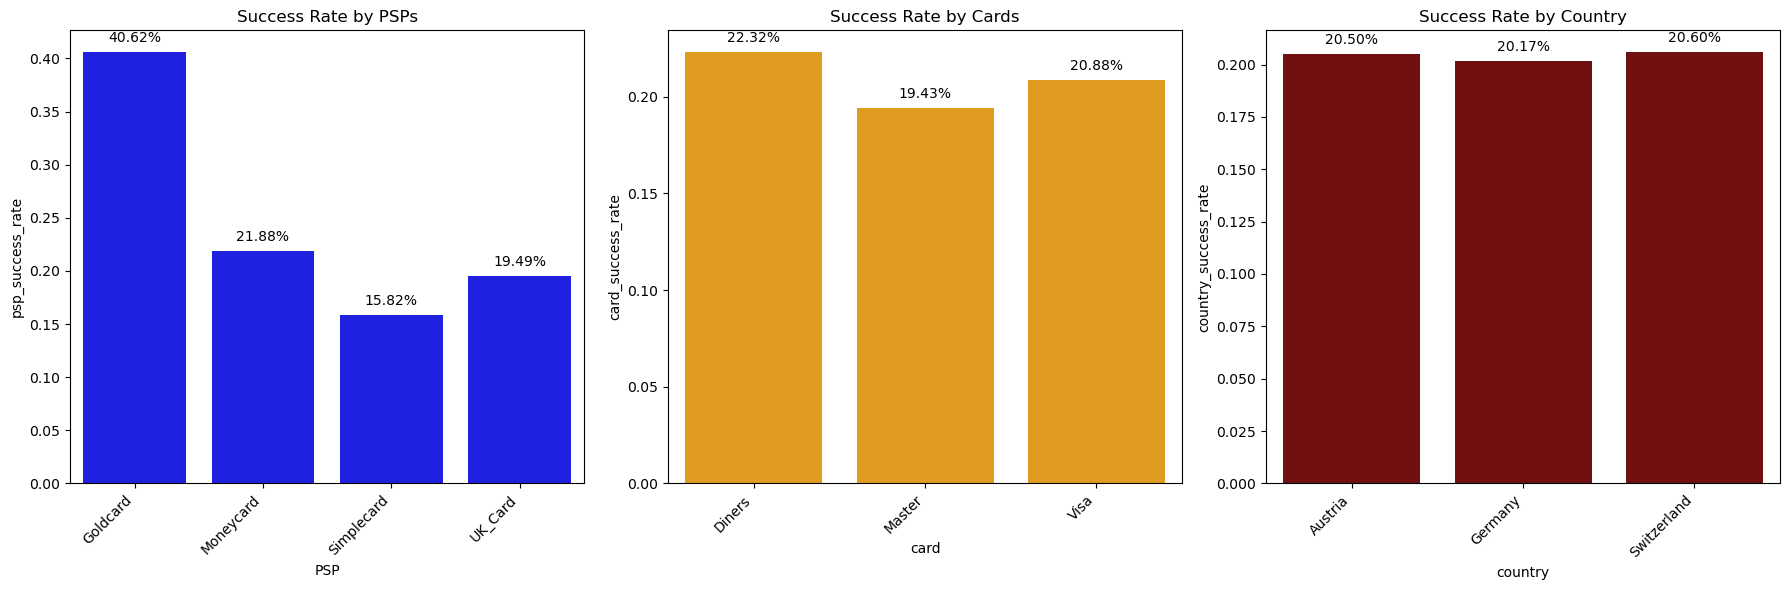

In [98]:
# Calculating Avg success rates
df2["psp_success_rate"] = df2.groupby(['PSP'])[['success']].transform('mean')
df2["card_success_rate"] = df2.groupby(['card'])[['success']].transform('mean')
df2["country_success_rate"] = df2.groupby(['country'])[['success']].transform('mean')

# Creating tables for PSPs, cards, countries and their success rates
rates = df2[["PSP","card","country","psp_success_rate","card_success_rate","country_success_rate"]]
psp_success_rate_df = rates.groupby(["PSP"])[["psp_success_rate"]].mean().reset_index()
card_success_rate_df = rates.groupby(["card"])[["card_success_rate"]].mean().reset_index()
country_success_rate_df = rates.groupby(["country"])[["country_success_rate"]].mean().reset_index()

display(psp_success_rate_df)
display(card_success_rate_df)
display(country_success_rate_df)

# Plotting the success rates
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='PSP', y='psp_success_rate', data=psp_success_rate_df, ax=axs[0], color='blue')
axs[0].set_title('Success Rate by PSPs')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
for p in axs[0].patches:
    axs[0].annotate(format(p.get_height(), '.2%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

sns.barplot(x='card', y='card_success_rate', data=card_success_rate_df, ax=axs[1], color='orange')
axs[1].set_title('Success Rate by Cards')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
for p in axs[1].patches:
    axs[1].annotate(format(p.get_height(), '.2%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

sns.barplot(x='country', y='country_success_rate', data=country_success_rate_df, ax=axs[2], color='maroon')
axs[2].set_title('Success Rate by Country')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, horizontalalignment='right')
for p in axs[2].patches:
    axs[2].annotate(format(p.get_height(), '.2%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

Success Rate by PSPs:

- This plot illustrates the average success rate for each Payment Service Provider (PSP). It helps in comparing the performance of different PSPs in terms of successfully processed transactions. It shows that Goldcard has the highest success rate of 40.62% and simplecard has the lowest success rate of 15.82%.

Success Rate by Cards:

- This plot shows the average success rate for each card type used in transactions. It provides insights into whether certain card types have higher success rates compared to others. It shows that Diners has the highest success rate of 22.32% and lowest success rate of 19.43%.

Success Rate by Country:

- This plot displays the average success rate for each country where transactions originate. It helps in understanding whether success rates vary significantly across different countries. It shows that switzerland has the highest success rate of 20.60% and Germany has the lowest success rate of 20.17%.

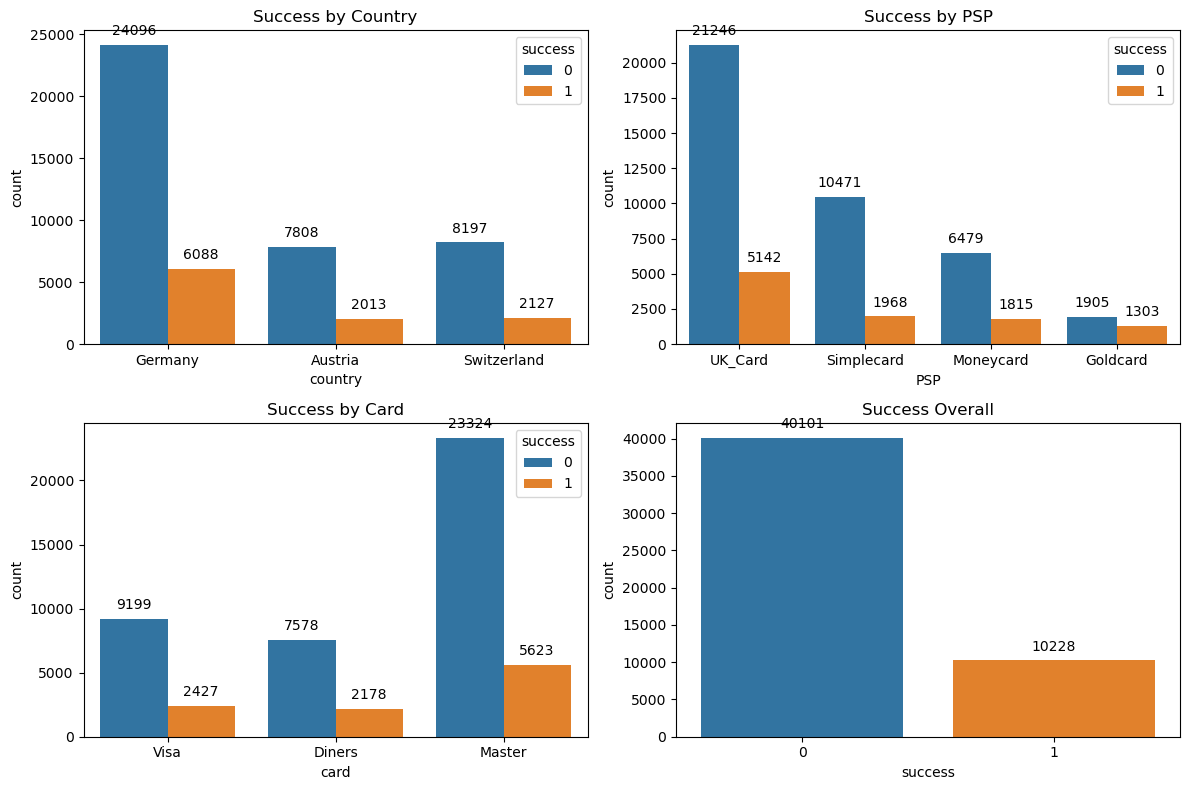

In [59]:
plt.figure(figsize=(12,8))

# Success by Country
plt.subplot(2,2,1)
ax1 = sns.countplot(data=df, x="country", hue="success")
plt.title("Success by Country")
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Success by PSP
plt.subplot(2,2,2)
ax2 = sns.countplot(data=df, x="PSP", hue="success")
plt.title("Success by PSP")
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Success by Card
plt.subplot(2,2,3)
ax3 = sns.countplot(data=df, x="card", hue="success")
plt.title("Success by Card")
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Success Overall
plt.subplot(2,2,4)
ax4 = sns.countplot(data=df, x="success")
plt.title("Success Overall")
for p in ax4.patches:
    ax4.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

Success by Country:

- This subplot shows the distribution of success (represented by hue) across different countries. It helps visualize whether success rates vary significantly between different countries.

Success by PSP (Payment Service Provider):

- This subplot displays the distribution of success (represented by hue) across different payment service providers. It helps analyze whether certain PSPs have higher success rates compared to others.

Success by Card:

- This subplot illustrates the distribution of success (represented by hue) across different card types. It provides insights into whether success rates differ based on the type of card used.

Success Overall:

- This subplot shows the overall distribution of success across the dataset. It provides a general overview of the success distribution without considering any specific categorical variable.

,success,TransactionCount
0,0,21639
1,1,5653


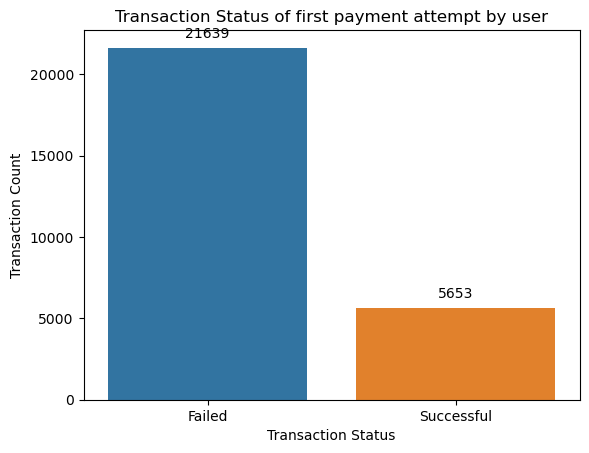

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the first payment attempt
first_attempt_df = df2[df2["noOfAttempts"]==1][["success"]].value_counts().reset_index(name = "TransactionCount")

# Display the DataFrame
display(first_attempt_df)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create a count plot
sns.barplot(x='success', y='TransactionCount', data=first_attempt_df, ax=ax)

# Set the title of the current axes
ax.set_title('Transaction Status of first payment attempt by user')

# Set the x and y-axis labels
ax.set_xlabel('Transaction Status')
ax.set_ylabel('Transaction Count')

# Update x-axis tick labels using dictionary
labels = {0: 'Failed', 1: 'Successful'}
ax.set_xticklabels([labels[0], labels[1]])

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Display the figure
plt.show()


,card,PSP,Transaction Type,Total Fee
23,Visa,UK_Card,failure_txnFee,6144.0
4,Master,Goldcard,success_txnFee,17630.0
6,Master,Simplecard,success_txnFee,7241.0
1,Diners,Moneycard,success_txnFee,8325.0
12,Diners,Goldcard,failure_txnFee,3350.0


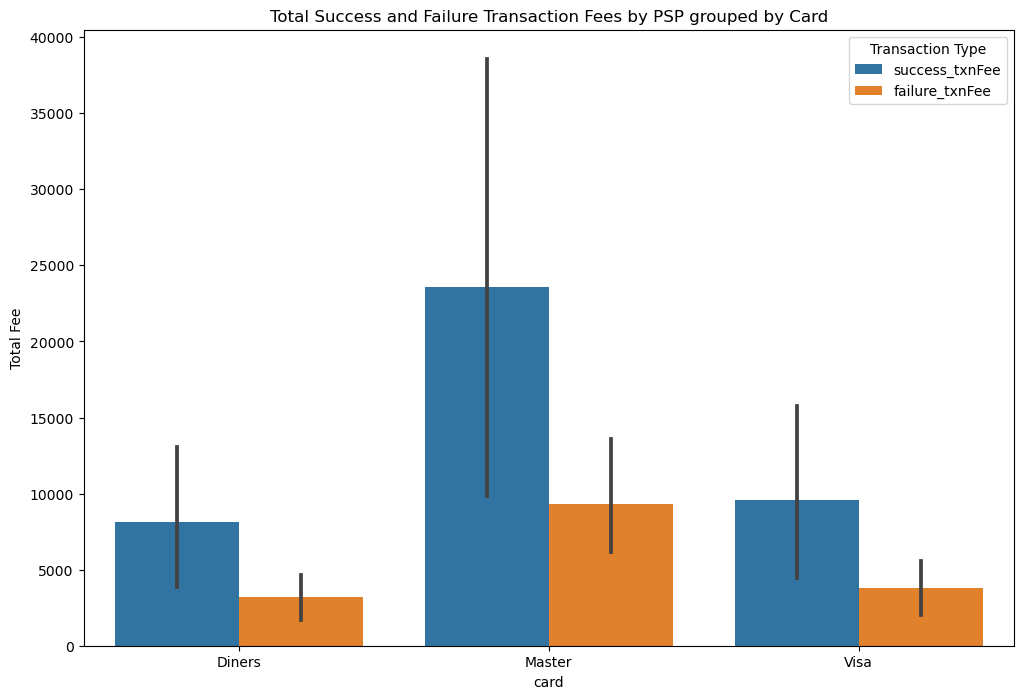

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'card' and 'PSP', and calculate the sum of 'success_txnFee' and 'failure_txnFee'
card_PSP = df2.groupby(["card","PSP"])[["success_txnFee","failure_txnFee"]].sum().reset_index()

# Melt the DataFrame to have 'Transaction Type' and 'Total Fee' columns
fee_summary = card_PSP.melt(id_vars=['card', 'PSP'], value_vars=['success_txnFee', 'failure_txnFee'],
                            var_name='Transaction Type', value_name='Total Fee')

# Display a sample of the DataFrame
display(fee_summary.sample(5))

# Create a figure and a set of subplots
fig, axs = plt.subplots(figsize=(12,8))

# Create a grouped bar plot for total success and failure transaction fees by PSP grouped by Card
sns.barplot(x='card', y='Total Fee', hue='Transaction Type', data=fee_summary, ax=axs)

# Set the title of the current axes
axs.set_title('Total Success and Failure Transaction Fees by PSP grouped by Card')

# Display the figure
plt.show()

It groups the dataframe df2 by the columns 'card' and 'PSP'. It calculates the sum of 'success_txnFee' and 'failure_txnFee' for each group.

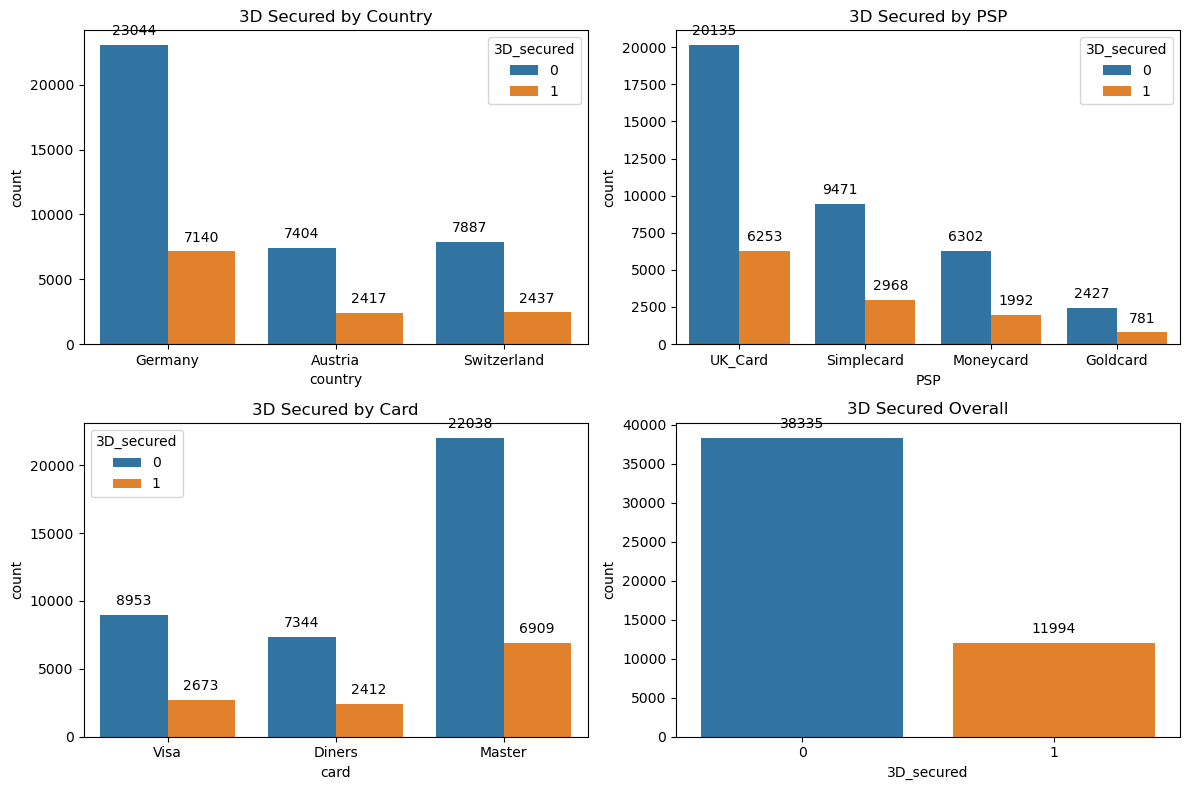

In [66]:
plt.figure(figsize=(12,8))

# 3D Secured by Country
plt.subplot(2,2,1)
ax1 = sns.countplot(data=df, x="country", hue="3D_secured")
plt.title("3D Secured by Country")
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# 3D Secured by PSP
plt.subplot(2,2,2)
ax2 = sns.countplot(data=df, x="PSP", hue="3D_secured")
plt.title("3D Secured by PSP")
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# 3D Secured by Card
plt.subplot(2,2,3)
ax3 = sns.countplot(data=df, x="card", hue="3D_secured")
plt.title("3D Secured by Card")
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# 3D Secured Overall
plt.subplot(2,2,4)
ax4 = sns.countplot(data=df, x="3D_secured")
plt.title("3D Secured Overall")
for p in ax4.patches:
    ax4.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

3D Secured by Country:
- This subplot shows the distribution of transactions marked as 3D secured (represented by hue) across different countries. It helps visualize whether 3D secure transactions are more prevalent in certain countries.

3D Secured by PSP (Payment Service Provider):
- This subplot displays the distribution of 3D secured transactions (represented by hue) across different payment service providers. It helps analyze whether certain PSPs have a higher proportion of 3D secured transactions compared to others.

3D Secured by Card:
- This subplot illustrates the distribution of 3D secured transactions (represented by hue) across different card types. It provides insights into whether 3D secure transactions are more common with specific card types.

3D Secured Overall:
- This subplot shows the overall distribution of 3D secured transactions across the dataset. It provides a general overview of the prevalence of 3D secured transactions without considering any specific categorical variable.

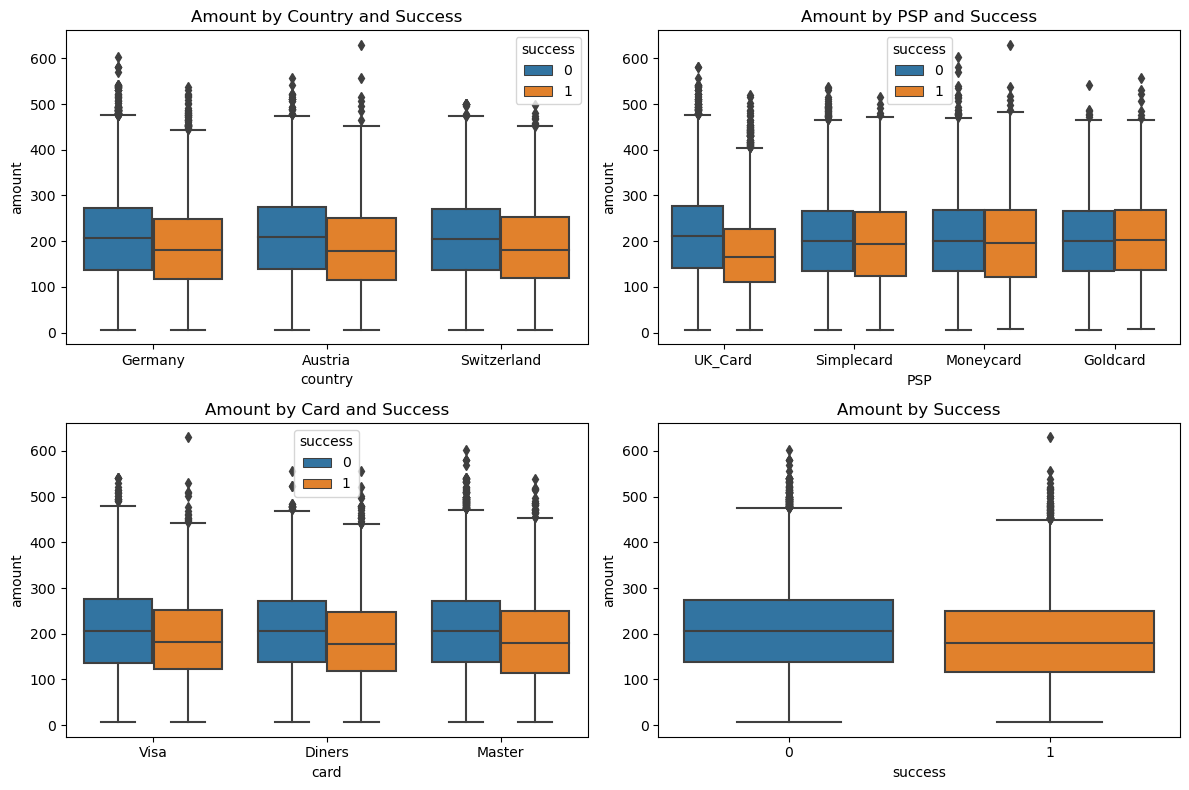

In [33]:
# Create box plots of the amount column by country, PSP, and card, grouped by success and 3D_secured
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.boxplot(data=df, x="country", y="amount", hue="success")
plt.title("Amount by Country and Success")
plt.subplot(2,2,2)
sns.boxplot(data=df, x="PSP", y="amount", hue="success")
plt.title("Amount by PSP and Success")
plt.subplot(2,2,3)
sns.boxplot(data=df, x="card", y="amount", hue="success")
plt.title("Amount by Card and Success")
plt.subplot(2,2,4)
sns.boxplot(data=df, x="success", y="amount")
plt.title("Amount by Success")
plt.tight_layout()
plt.show()

Amount by Country and Success:
- This subplot displays box plots of transaction amounts grouped by country and success status.It helps visualize the distribution of transaction amounts across different countries, distinguishing between successful and unsuccessful transactions.The box plots allow for easy comparison of the central tendency, spread, and skewness of transaction amounts within each category.

Amount by PSP and Success:
- This subplot illustrates box plots of transaction amounts grouped by payment service provider (PSP) and success status. It aids in understanding how transaction amounts vary across different PSPs, considering both successful and unsuccessful transactions.

Amount by Card and Success:
- This subplot presents box plots of transaction amounts grouped by card type and success status. It provides insights into the distribution of transaction amounts across different card types, differentiated by success status.

Amount by Success:
- This subplot shows box plots of transaction amounts grouped solely by success status. It gives a general overview of how transaction amounts differ between successful and unsuccessful transactions.

In [70]:
# Extract numeric columns for correlation analysis
numeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns
numeric_df = df2[numeric_columns]

In [71]:
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

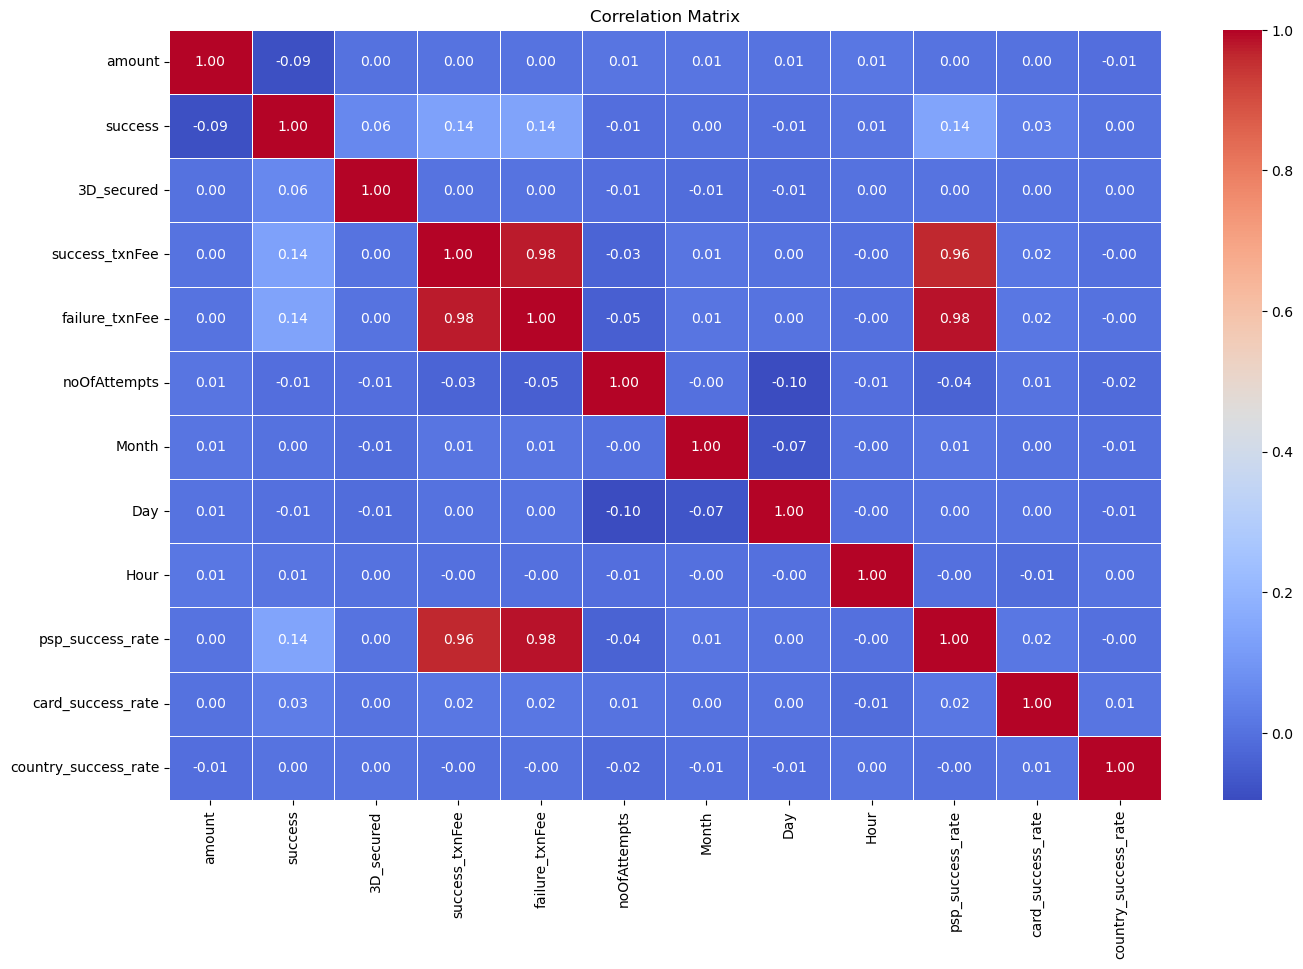

In [102]:
# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

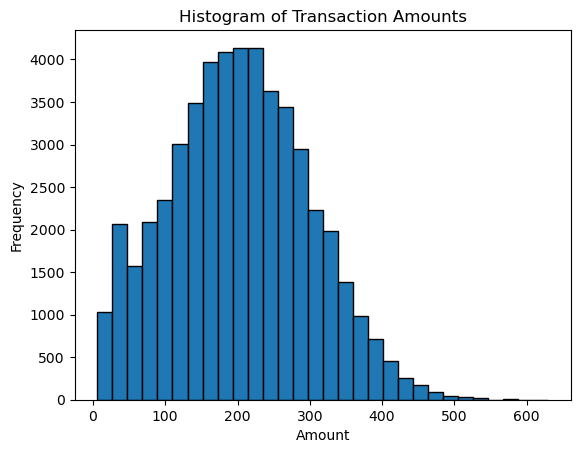

In [103]:
# Histogram of transaction amounts
plt.hist(df2['amount'], bins=30, edgecolor='black')
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

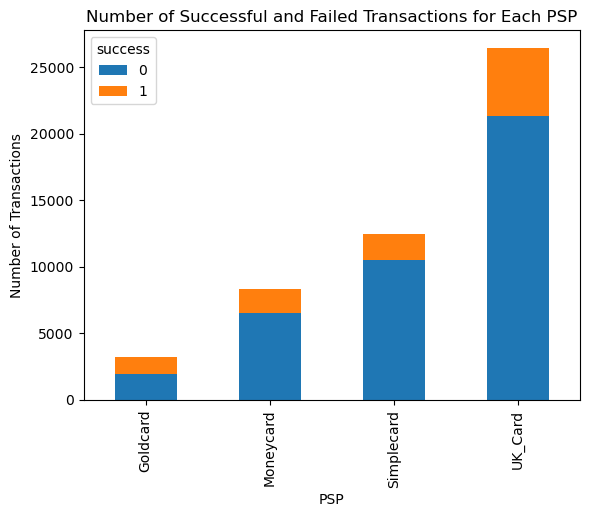

In [39]:
# Bar chart of successful and failed transactions for each PSP
df.groupby('PSP')['success'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Number of Successful and Failed Transactions for Each PSP')
plt.xlabel('PSP')
plt.ylabel('Number of Transactions')
plt.show()

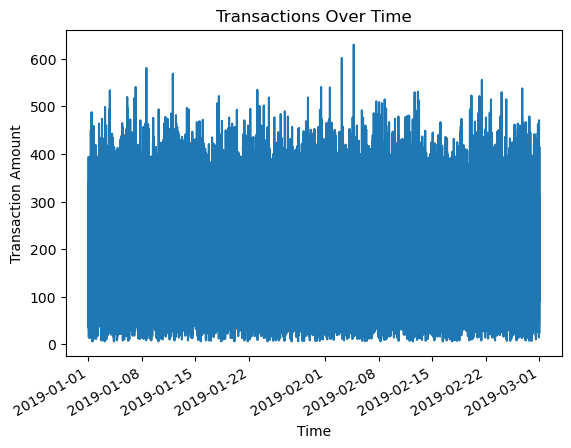

In [40]:
# Time series plot of transactions over time
df.set_index('tmsp')['amount'].plot()
plt.title('Transactions Over Time')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.show()

PSP
Goldcard      0.406172
Moneycard     0.218754
Simplecard    0.158123
UK_Card       0.194338
Name: success, dtype: float64


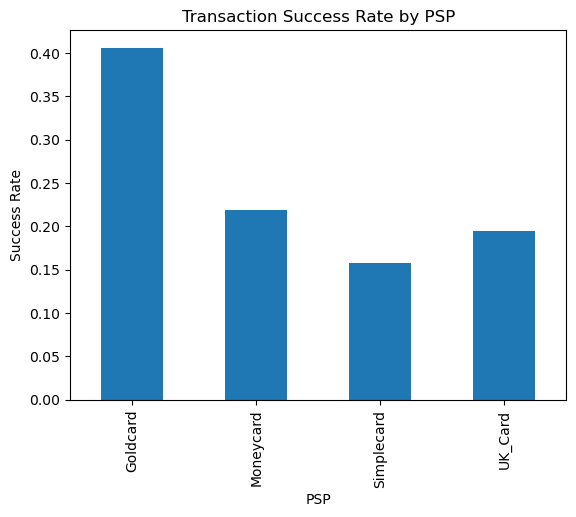

In [41]:
success_rate_by_psp = df.groupby('PSP')['success'].mean()
print(success_rate_by_psp)
success_rate_by_psp.plot(kind='bar')
plt.title('Transaction Success Rate by PSP')
plt.xlabel('PSP')
plt.ylabel('Success Rate')
plt.show()

card
Diners    0.222973
Master    0.193883
Visa      0.208505
Name: success, dtype: float64


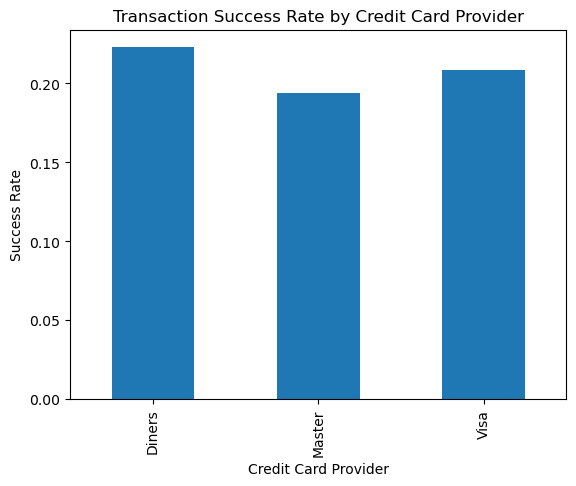

In [42]:
success_rate_by_card = df.groupby('card')['success'].mean()
print(success_rate_by_card)
success_rate_by_card.plot(kind='bar')
plt.title('Transaction Success Rate by Credit Card Provider')
plt.xlabel('Credit Card Provider')
plt.ylabel('Success Rate')
plt.show()

3D_secured
0    0.189562
1    0.245525
Name: success, dtype: float64


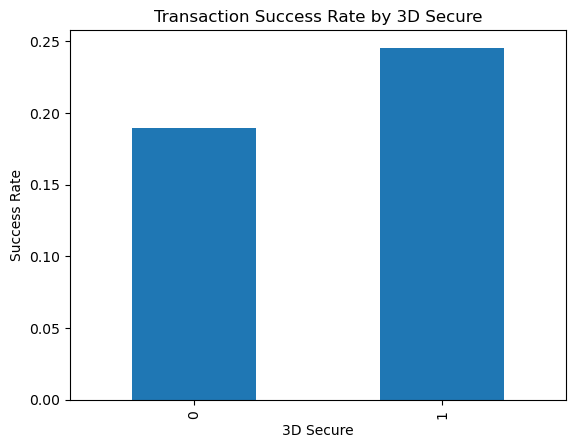

In [43]:
success_rate_by_3d_secure = df.groupby('3D_secured')['success'].mean()
print(success_rate_by_3d_secure)
success_rate_by_3d_secure.plot(kind='bar')
plt.title('Transaction Success Rate by 3D Secure')
plt.xlabel('3D Secure')
plt.ylabel('Success Rate')
plt.show()

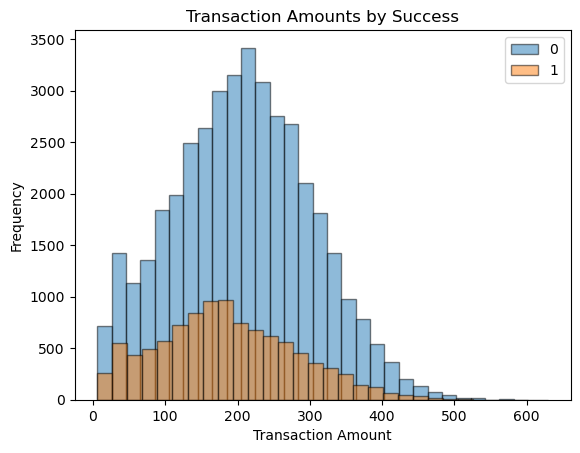

In [44]:
df.groupby('success')['amount'].plot(kind='hist', legend=True, alpha=0.5, bins=30, edgecolor='black')
plt.title('Transaction Amounts by Success')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [104]:
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday,psp_success_rate,card_success_rate,country_success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,1,1,1,0,Tuesday,0.194861,0.208756,0.201696
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,2,1,1,0,Tuesday,0.194861,0.208756,0.201696
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,1,1,1,0,Tuesday,0.194861,0.223247,0.201696
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,2,1,1,0,Tuesday,0.194861,0.223247,0.201696
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,1,1,1,0,Tuesday,0.158212,0.223247,0.204969


In [108]:
# Display the number of attempts
attempts_count = df2['noOfAttempts'].value_counts()
print(attempts_count)

noOfAttempts
1     27292
2     12306
3      5710
4      2655
5      1247
6       608
7       287
8       144
9        79
10        1
Name: count, dtype: int64


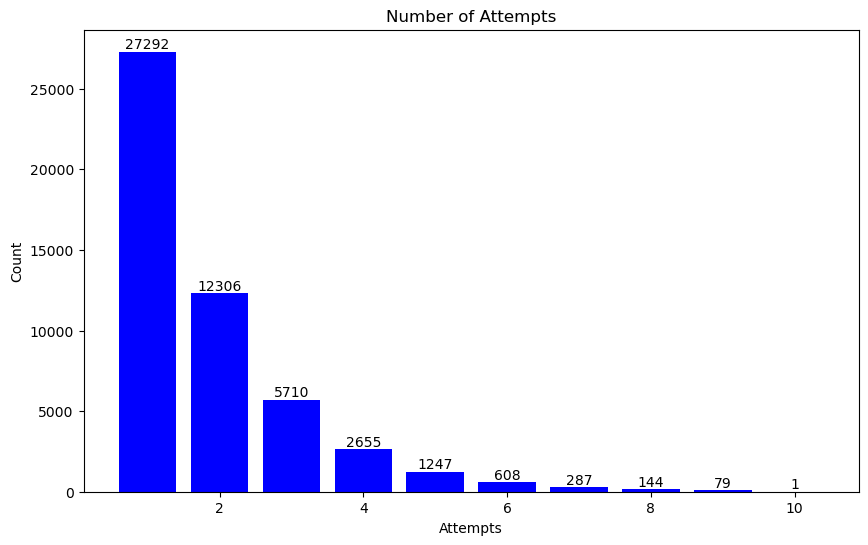

In [112]:
# Get the number of attempts
attempts_count = df2['noOfAttempts'].value_counts()

# Create a new figure
plt.figure(figsize=(10,6))

# Create a bar plot
bars = plt.bar(attempts_count.index, attempts_count.values, color='blue')

# Set the title and labels
plt.title('Number of Attempts')
plt.xlabel('Attempts')
plt.ylabel('Count')

# Annotate each bar with its height value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Show the plot
plt.show()


In [113]:
psp_df.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,1,89,0,3,0,2,3,1.0,1,1,1,0,5
1,2019-01-01 00:01:17,1,89,1,3,0,2,3,1.0,2,1,1,0,5
2,2019-01-01 00:02:49,1,238,0,3,1,0,3,1.0,1,1,1,0,5
3,2019-01-01 00:03:13,1,238,1,3,1,0,3,1.0,2,1,1,0,5
4,2019-01-01 00:04:33,0,124,0,2,0,0,1,0.5,1,1,1,0,5


# 4. Model Building and Evaluation

In [121]:
X = df4.drop(["tmsp","success"],axis=1)
y = df4['success']

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.1 Baseine Model

Training set:
Accuracy: 0.7988724138787472
Precision: 0.7546017498900598
Recall: 0.7988724138787472
F1 Score: 0.7175445619170696
Confusion Matrix:
[[31963   151]
 [ 7947   202]]


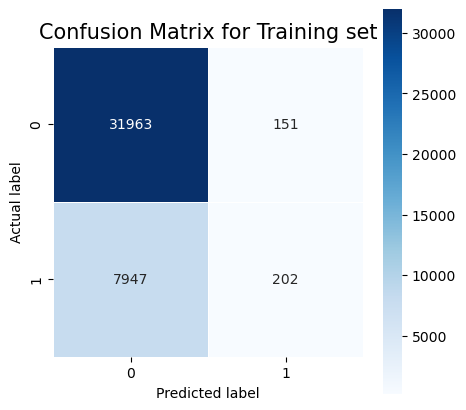

Testing set:
Accuracy: 0.7911782237234254
Precision: 0.7059777579692178
Recall: 0.7911782237234254
F1 Score: 0.7065566749652985
Confusion Matrix:
[[7933   54]
 [2048   31]]


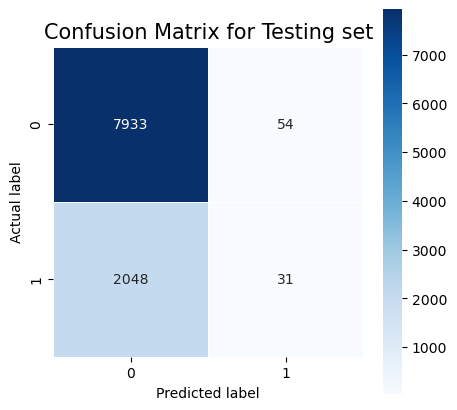

In [126]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model initialization
model = LogisticRegression(solver='liblinear')

# Define hyperparameters for grid search
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Function to evaluate the model
def evaluate_model(model, X, y, dataset):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)

    print(f"{dataset} set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title(f'Confusion Matrix for {dataset} set', size = 15);
    plt.show()

# Evaluate the best model on the training set
evaluate_model(best_model, X_train_scaled, y_train, "Training")

# Evaluate the best model on the testing set
evaluate_model(best_model, X_test_scaled, y_test, "Testing")


- This code is used for building, tuning, and evaluating a logistic regression classifier for binary classification tasks.
- By utilizing hyperparameter tuning with grid search, it helps in finding the optimal hyperparameters for the logistic regression model, thereby improving its performance.
- The evaluation metrics (accuracy, precision, recall, F1 score) and the confusion matrix provide a comprehensive understanding of the model's performance on both training and testing datasets.
- The visualization of the confusion matrix aids in identifying areas where the model may be misclassifying instances, which can inform further refinement of the model or the dataset.
- Overall, this code serves as a valuable tool for assessing and refining logistic regression models for binary classification tasks.

## 4.2 Accurate Model

Training set:
Accuracy: 0.8344634031244567
Precision: 0.8399100861678356
Recall: 0.8344634031244567
F1 Score: 0.7917160910280461
Confusion Matrix:
[[31849   265]
 [ 6400  1749]]


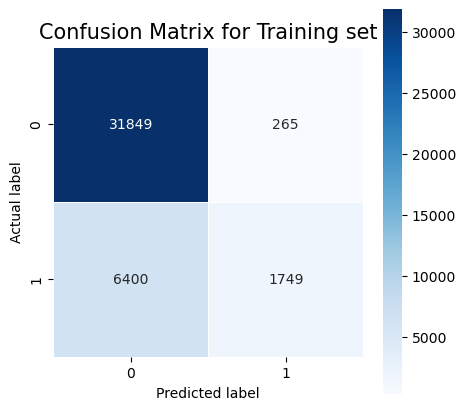

Testing set:
Accuracy: 0.7923703556526922
Precision: 0.7391645945858292
Recall: 0.7923703556526922
F1 Score: 0.7318667105842152
Confusion Matrix:
[[7782  205]
 [1885  194]]


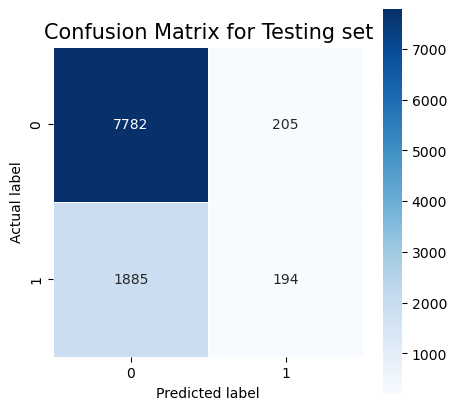

In [127]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the XGBoost classifier
clf = xgb.XGBClassifier()
clf.fit(X_train_scaled, y_train)

# Function to evaluate the model
def evaluate_model(model, X, y, dataset):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)

    print(f"{dataset} set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title(f'Confusion Matrix for {dataset} set', size = 15);
    plt.show()

# Evaluate the model on the training set
evaluate_model(clf, X_train_scaled, y_train, "Training")

# Evaluate the model on the testing set
evaluate_model(clf, X_test_scaled, y_test, "Testing")


- XGBoost is a powerful machine learning algorithm known for its efficiency and effectiveness in various classification tasks.
- This code trains an XGBoost classifier on the training data and evaluates its performance on both training and testing datasets.
- By evaluating metrics such as accuracy, precision, recall, and F1 score, the code provides a comprehensive understanding of the model's performance.
- The confusion matrix visualization further aids in understanding how well the model is performing in terms of correctly classifying instances and identifying areas where it may be misclassifying instances.
- Overall, this code serves as a valuable tool for training and evaluating XGBoost classifiers for classification tasks, providing insights into model performance and potential areas for improvement.

In [129]:
# Function to compute evaluation metrics
def compute_metrics(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Compute evaluation metrics for both models on the training set
accuracy_train1, precision_train1, recall_train1, f1_train1 = compute_metrics(best_model, X_train_scaled, y_train)
accuracy_train2, precision_train2, recall_train2, f1_train2 = compute_metrics(clf, X_train_scaled, y_train)

# Compute evaluation metrics for both models on the testing set
accuracy_test1, precision_test1, recall_test1, f1_test1 = compute_metrics(best_model, X_test_scaled, y_test)
accuracy_test2, precision_test2, recall_test2, f1_test2 = compute_metrics(clf, X_test_scaled, y_test)

# Create a DataFrame to display the evaluation metrics
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Logistic Regression (Train)': [accuracy_train1, precision_train1, recall_train1, f1_train1],
    'XGBoost (Train)': [accuracy_train2, precision_train2, recall_train2, f1_train2],
    'Logistic Regression (Test)': [accuracy_test1, precision_test1, recall_test1, f1_test1],
    'XGBoost (Test)': [accuracy_test2, precision_test2, recall_test2, f1_test2]
})

print(metrics)

      Metric  Logistic Regression (Train)  XGBoost (Train)  \
0   Accuracy                     0.798872         0.834463   
1  Precision                     0.754602         0.839910   
2     Recall                     0.798872         0.834463   
3   F1 Score                     0.717545         0.791716   

   Logistic Regression (Test)  XGBoost (Test)  
0                    0.791178        0.792370  
1                    0.705978        0.739165  
2                    0.791178        0.792370  
3                    0.706557        0.731867  


# 5. Model Deployment

**Proposal for Model Deployment:**

To integrate the predictive model into the company's operational workflow, we propose a phased approach that emphasizes usability, practicality, and seamless integration with existing systems. The deployment options considered include embedding the model within existing systems, developing a standalone application, or implementing a graphical user interface (GUI). Each option offers unique benefits and considerations, which are outlined below:

**1. Embedding within Existing Systems:**

- Description: In this approach, the predictive model is integrated directly into the company's existing transaction processing system.

- Benefits:

    - Seamless Integration: Embedding the model within existing systems ensures a seamless transition and minimal disruption to current workflows.
    - Real-time Decision-Making: With the model embedded within the transaction processing system, decisions regarding credit card routing can be made in real-time, improving efficiency and responsiveness.
    - Reduced Manual Intervention: By automating the credit card routing process, this approach reduces the need for manual intervention, thereby streamlining operations and reducing the risk of errors.

- Considerations:
    - Technical Integration: Integration with existing systems may require coordination with IT departments and adherence to specific technical requirements.
    - System Compatibility: Compatibility with existing systems and infrastructure must be ensured to prevent conflicts or performance issues.
    
**2. Standalone Application:**

- Description: A standalone application is developed to host the predictive model, providing a dedicated platform for credit card routing decisions.

- Benefits:

    - Flexibility and Customization: A standalone application offers flexibility in terms of customization and user interface design, allowing for tailored user experiences and workflows.
    - Centralized Management: By centralizing the predictive model within a standalone application, it becomes easier to manage and maintain, with updates and improvements implemented as needed.
    - Enhanced Security: Hosting the model within a dedicated application may enhance security measures, protecting sensitive transaction data and ensuring compliance with regulatory requirements.
    
- Considerations:

    - User Training: Users may require training to effectively utilize the standalone application and understand its functionalities.
    - Development and Maintenance: Developing and maintaining a standalone application entails additional costs and resources, requiring ongoing support from development teams.
    
**3. Graphical User Interface (GUI):**

- Description: A graphical user interface (GUI) is developed to provide an intuitive interface for interacting with the predictive model.

- Benefits:

    - User-Friendly Interface: A GUI offers a user-friendly interface that simplifies interaction with the predictive model, allowing users to input data, view results, and make decisions easily.
    - Accessibility: A GUI can be accessed from any device with internet connectivity, providing flexibility and accessibility for users across different departments or locations.
    - Visualizations and Insights: The GUI can incorporate visualizations and insights generated by the predictive model, enhancing user understanding and facilitating decision-making.
    
- Considerations:

    - Design and Usability: Designing an effective GUI requires careful consideration of user experience (UX) principles and usability testing to ensure intuitive navigation and functionality.
    - Integration with Backend Systems: The GUI must be integrated with backend systems to retrieve data and communicate with the predictive model effectively.

# Conclusion

Accuracy:

- For the training dataset, XGBoost outperforms logistic regression with an accuracy of 83.45% compared to 79.89%.However, on the testing dataset, logistic regression slightly underperforms XGBoost with an accuracy of 79.12% compared to 79.24%.

Precision:

- XGBoost demonstrates higher precision on both training and testing datasets compared to logistic regression. This indicates that XGBoost has a better ability to correctly identify positive instances (true positives) while minimizing false positives.

Recall:

- Recall values for both logistic regression and XGBoost are similar for both training and testing datasets, indicating their ability to identify true positives among all actual positive instances.

F1 Score:

- XGBoost achieves a higher F1 score on both training and testing datasets compared to logistic regression, suggesting a better balance between precision and recall.

Overall, XGBoost exhibits superior performance in terms of accuracy, precision, and F1 score compared to logistic regression, especially on the training dataset. However, logistic regression still demonstrates competitive performance, particularly on the testing dataset. Further analysis may be needed to understand the reasons behind the differences in performance and to optimize both models accordingly.